In [1]:
import sys; sys.path.insert(0,'../')
from notebook_tools import *
from matplotlib.ticker import LinearLocator
%matplotlib inline

# load data

In [2]:
def read_sims_remove_unreconstructed_runs( filename='' ):
    sample = pd.read_csv(filename)
    sample=sample[sample['parameters_reconstructed_well']==True]
#     sample=sample[sample['parameters_reconstructed_well']=='True']
    sample.fillna(0.0,inplace=True)
    print len(sample),'runs in the sample\n',filename
    return sample

In [3]:
sims = read_sims_remove_unreconstructed_runs('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/random_parameters_results/OrTrees_BinomTest_results.csv')

4670 runs in the sample
/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/random_parameters_results/OrTrees_BinomTest_results.csv


In [38]:
sims = read_sims_remove_unreconstructed_runs('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation/runs_0_10_simulationruns_results.csv')

22 runs in the sample
/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation/runs_0_10_simulationruns_results.csv


In [4]:
sample = sims

## can the number of attempts be used to kill large b_2?

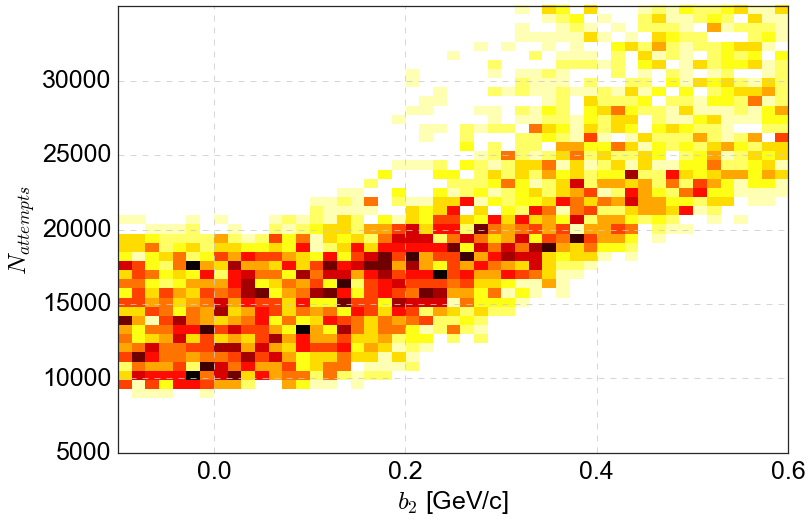

In [5]:
fig,ax=plt.subplots(figsize=(12,8))
plot_2d_hist(sample['gen_b2'],sample['Nattempts'],bins=(np.linspace(-0.1,0.6,50),np.linspace(5000,35000,50)),ax=ax);
set_axes(ax,'$b_2$ [GeV/c]','$N_{attempts}$'
         ,xticks=[0.0,0.2,0.4,0.6],yticks=[5000,10000,15000,20000,25000,30000]
         ,do_add_grid=True)

## sigma_t

In [6]:
def find_fractional_integral_from_bin( h, bins, bin0 , Nsigmas=1, side='left' , debug=0 ):
    # find the fractional integral from bin0 to fraction to the left or to the right
    
    if Nsigmas == 1:
        fraction = 0.6827 
    elif Nsigmas == 2:
        fraction = 0.9545 

    bin_width = bins[1]-bins[0]
    if side=='left':
        Integral_tot_from_bin0_to_side = bin_width * np.sum( h[0 : bin0] )
        if debug:
            print 'Integral_tot_from_bin0_to_side',side,':',Integral_tot_from_bin0_to_side
        for tmp_bin in range(0,bin0):
            Integral_from_bin0_to_side = bin_width * np.sum( h[ bin0-tmp_bin : bin0 ] )
            if (Integral_from_bin0_to_side / Integral_tot_from_bin0_to_side) >= fraction:
                required_fraction_bin = bin0-tmp_bin
                required_fraction_x = bins[required_fraction_bin]
                if debug:
                    print 'required_fraction_bin:',required_fraction_bin
                    print 'required_fraction_x:',required_fraction_x
                return required_fraction_bin,required_fraction_x
    elif side=='right':        
        Integral_tot_from_bin0_to_side = bin_width * np.sum( h[bin0:len(bins)] )
        if debug:
            print 'Integral_tot_from_bin0_to_side',side,':',Integral_tot_from_bin0_to_side
        for tmp_bin in range(bin0,len(bins)):
            Integral_from_bin0_to_side = bin_width * np.sum( h[ bin0:tmp_bin ] )
            if (Integral_from_bin0_to_side / Integral_tot_from_bin0_to_side) >= fraction:
                required_fraction_bin = tmp_bin
                required_fraction_x = bins[required_fraction_bin-1]
                if debug:
                    print 'required_fraction_bin:',required_fraction_bin
                    print 'required_fraction_x:',required_fraction_x
                return required_fraction_bin,required_fraction_x        
    
def Plot_distribution_MPV_and_sigma( x , weights , bins=None , debug=0 , do_plot=False,color='black'):
    # first step: find the Most Probable Value
    h,edges=np.histogram(x,weights=weights,bins=bins)
    bins = (edges[:-1] + edges[1:]) / 2
    argmax = np.argmax(h)
    xmax = bins[argmax]
    ax = plt.gca()
    if do_plot:
        plt.bar(bins, h, align='center',width=0.7 * (edges[1] - edges[0]))
        plt.plot([bins[argmax],bins[argmax]],[0,h[argmax]],'--',color='black')

    # second step: find the 1\sigma confidence (68% integral) to the left and to the right    
    bin_left,x_left = find_fractional_integral_from_bin( h, bins, argmax , Nsigmas=1, side='left' , debug=debug )
    if do_plot: plt.plot([x_left,x_left],[0,h[bin_left]],'-',color=color)
    uncertainty_left = xmax-x_left
    bin_right,x_right = find_fractional_integral_from_bin( h, bins, argmax , Nsigmas=1, side='right' , debug=debug )
    if do_plot: plt.plot([x_right,x_right],[0,h[bin_right-1]],'-',color=color)
    uncertainty_right = x_right-xmax

    if debug:
        print 'mean:',np.average(x , weights=weights)
        print 'argmax:',argmax
        print 'xmax:',xmax
        print 'h[argmax]:',h[argmax]
        print 'x_left:',x_left
        print 'x_right:',x_right
        print 'result: ',xmax,'+',uncertainty_right,'-',uncertainty_left
        
    return xmax , uncertainty_left , uncertainty_right , bin_left , bin_right

result:  0.479797979798 + 0.111111111111 - 0.0909090909091


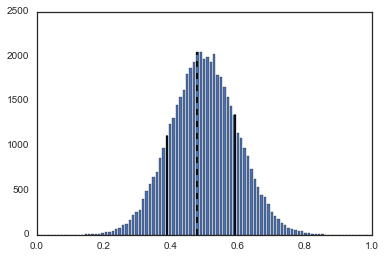

In [7]:
# example
x = np.random.normal(0.5,0.1,50000)
weights = np.random.uniform(0,1,len(x))
# Plot_distribution_MPV_and_sigma( x=x , weights=weights , bins=np.linspace(0,1,500) , debug=1 )
MPV,err_left,err_right,_,_ = Plot_distribution_MPV_and_sigma( x=x , weights=None ,do_plot=True, bins=np.linspace(0,1,100) , debug=0 , color='black' )
print 'result: ',MPV,'+',err_right,'-',err_left

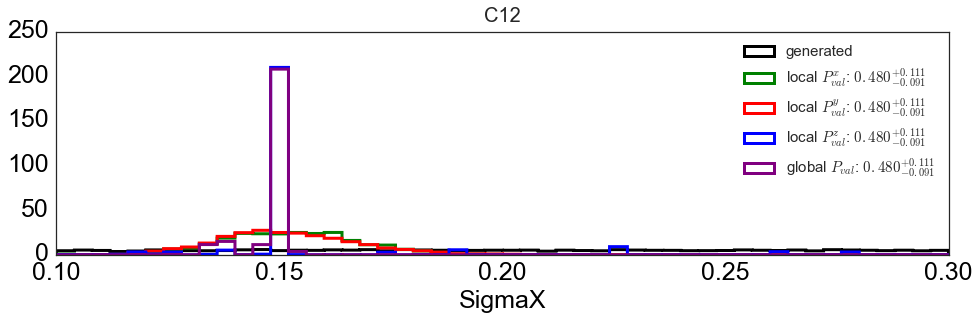

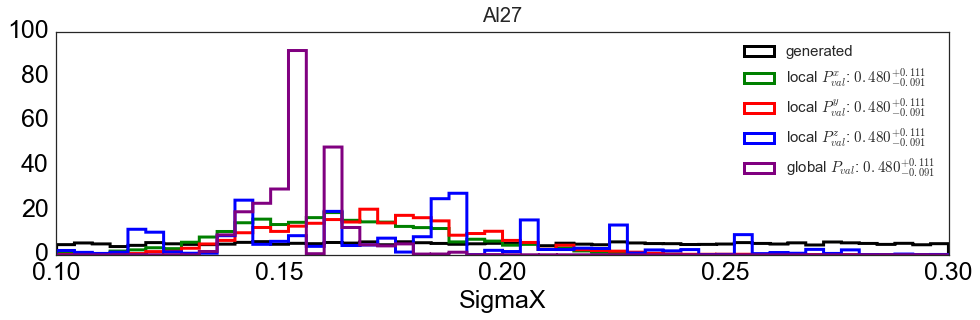

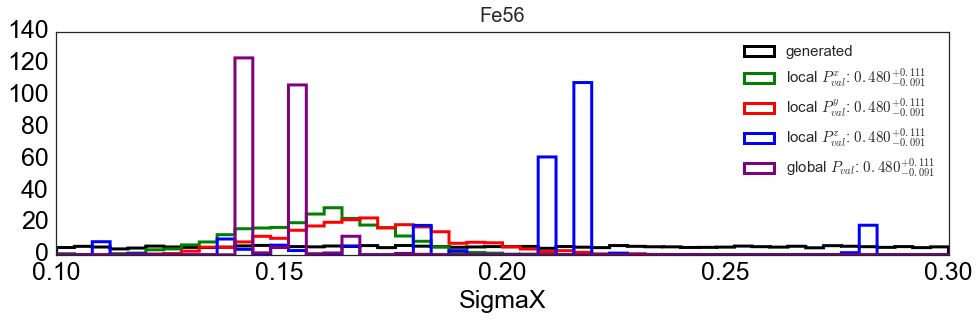

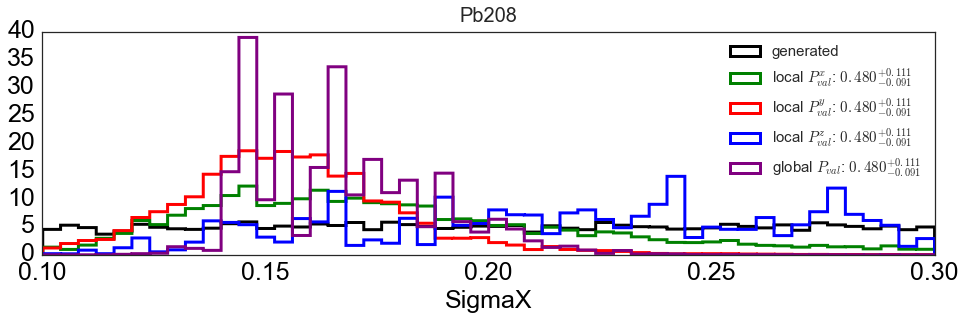

In [8]:
parameter = 'SigmaX'

for target in ['C12','Al27','Fe56','Pb208']:    
    fig,ax = plt.subplots(figsize=(16,4))
    x = sample['gen_'+parameter] 
    h,bins,_=plt.hist(x,bins=50,normed=1,histtype='step',linewidth=3,color='black',label='generated')
    weights_array = [
        'ks_local_Pval_pcmX_'+target,        
        'ks_local_Pval_pcmY_'+target,        
        'ks_local_Pval_pcmZ_Fisher_'+target,        
#         'ks_Pval_pcmX_pcmY_pcmZ_scaled_1e20_'+target,
        'Pval_pcmXYZ_Fisher_binom_0.20_'+target,
        'Pval_pcmXYZ_Fisher_binom_0.20_'+target,

#         'ks_PvalTotal_'+target,
#         'PvalTotal_binom_'+target,
    ] 
    labels = [
        'local $P_{val}^{x}$',
        'local $P_{val}^{y}$',
        'local $P_{val}^{z}$',
#         'global $P_{val}$',
        'global $P_{val}$',
#         'ks_PvalTotal_'+target,
    ]    
    colors = ['green','red','blue','purple','salmon','black','cyan','yellow']
    y_max,mu,sigma=0,[],[]
    for i,weights_name,color,label in zip(range(len(weights_array)),weights_array,colors,labels):
        weights = sample[weights_name]
        if np.sum(weights)>0:
#             MPV,err_left,err_right,bin_left,bin_right = Plot_distribution_MPV_and_sigma( x=x , weights=weights 
#                                                                                         , bins=bins , debug=0 
#                                                                                         , color=color)
            h,bins,_=plt.hist(x,weights=weights,bins=bins,normed=1,histtype='step',linewidth=3
                              ,color=color,label=label+': $%.3f_{-%.3f}^{+%.3f}$'%(MPV,err_left,err_right));
#             plt.plot([MPV-err_left,MPV-err_left],[0,h[bin_left]],'--',color=color)
#             plt.plot([MPV+err_right,MPV+err_right],[0,h[bin_right-1]],'--',color=color)
            if np.max(h)>y_max: y_max=np.max(h)
        else: print weights_name,'sum to 0'
    ax.legend(loc='best',fontsize=15)
    set_axes(ax,x_label=parameter,fontsize=25)
    ax.set_title(target,fontsize=20,y=1.02)    

plotting C12
plotting Al27
plotting Fe56
plotting Pb208


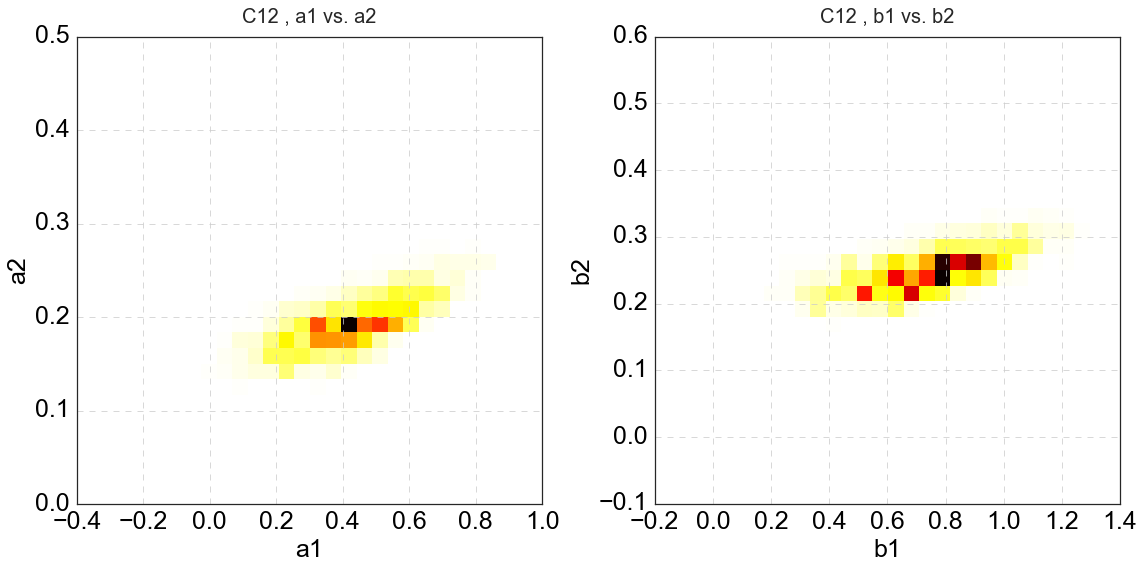

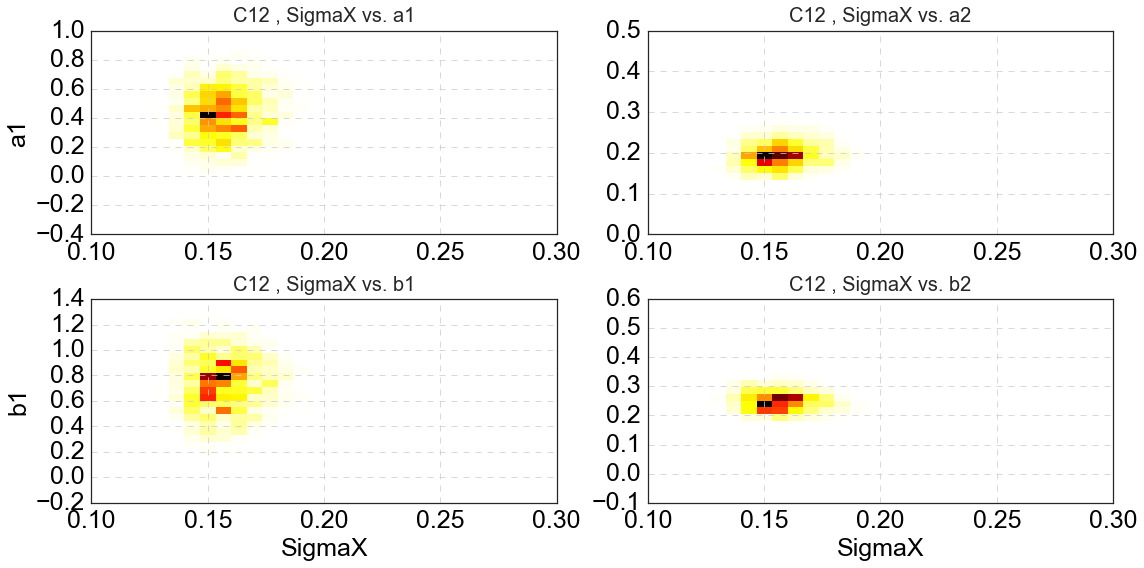

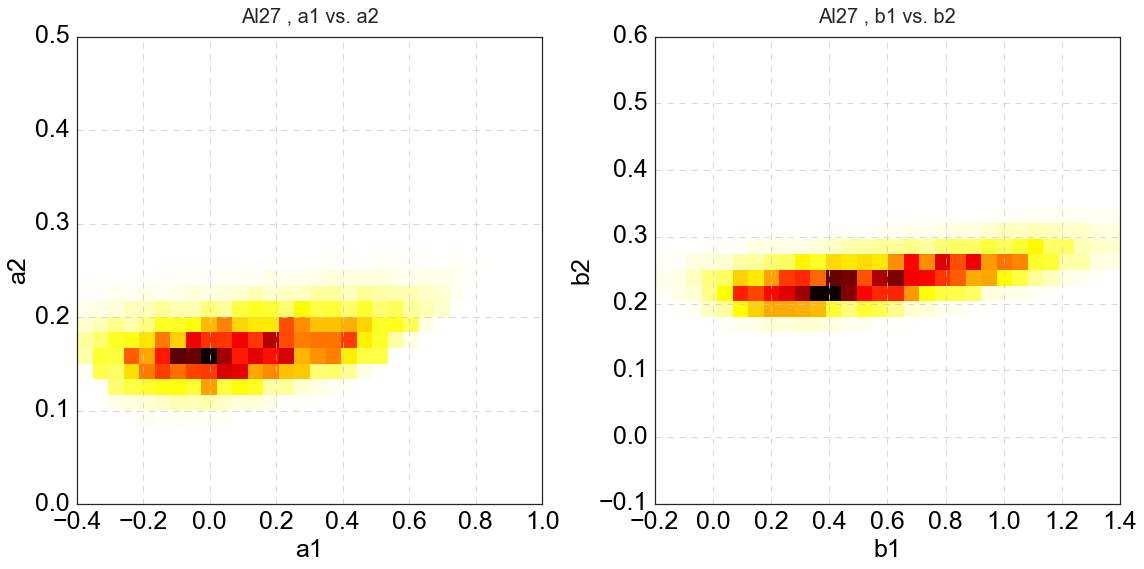

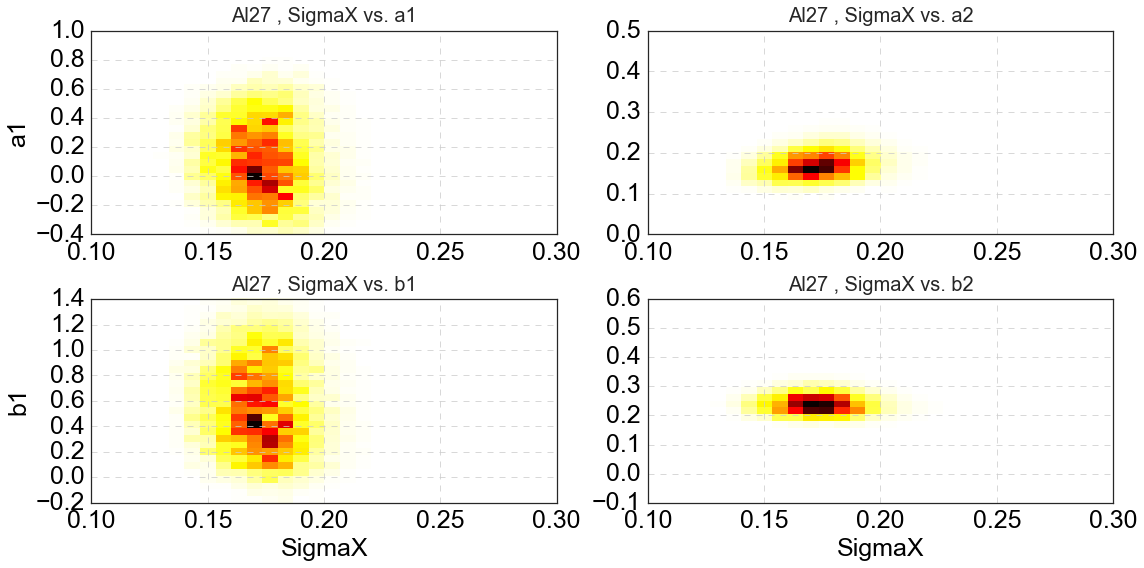

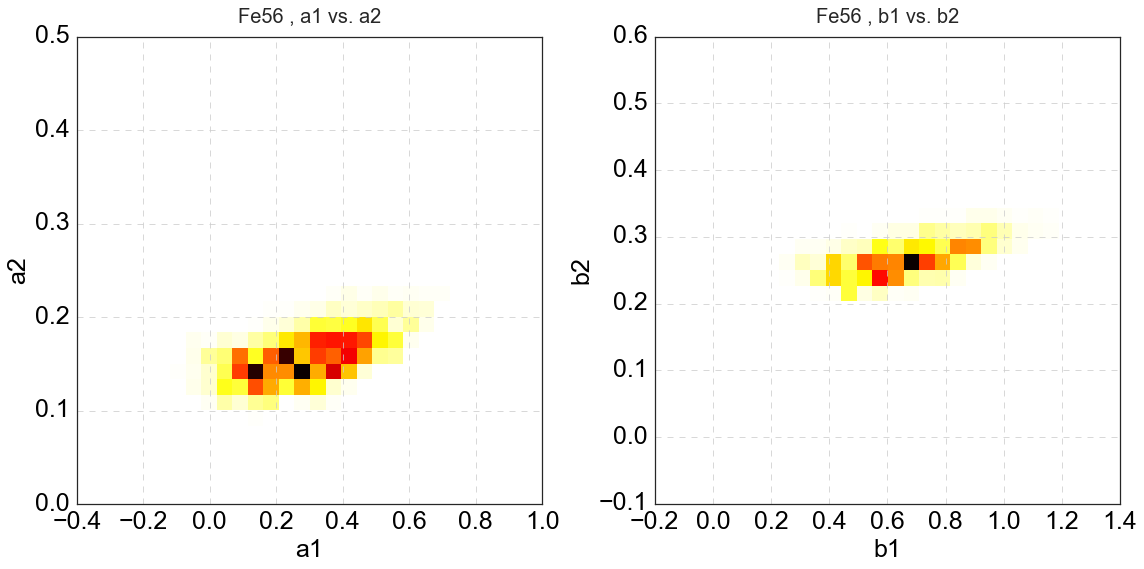

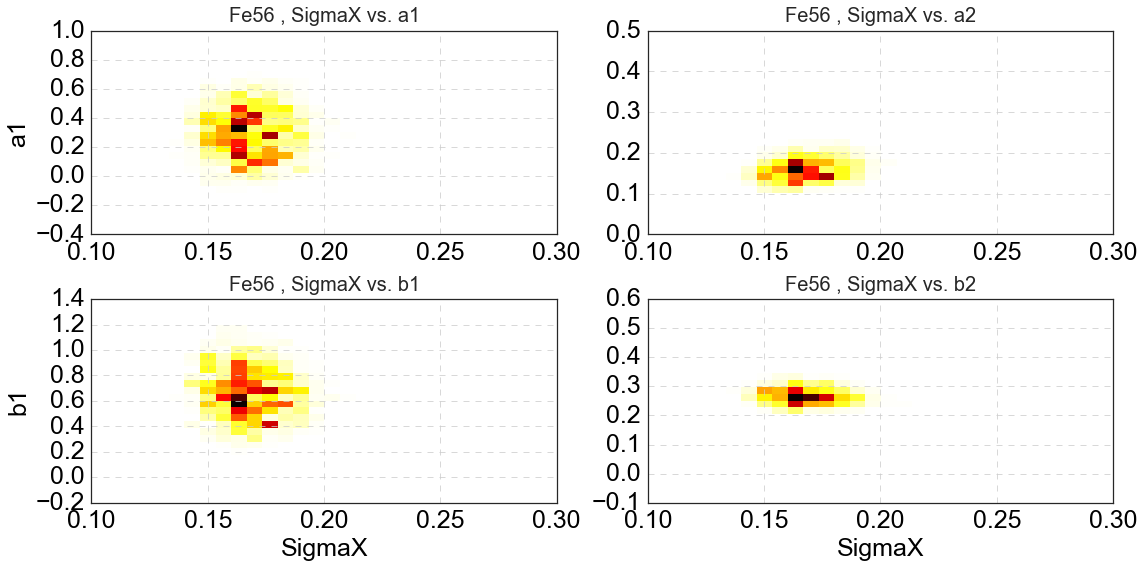

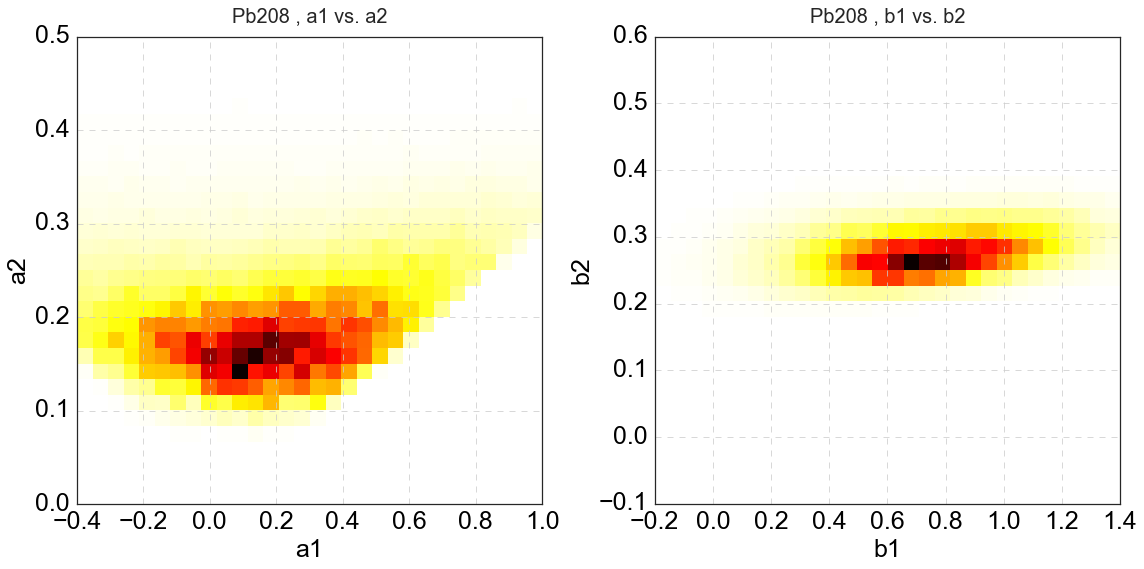

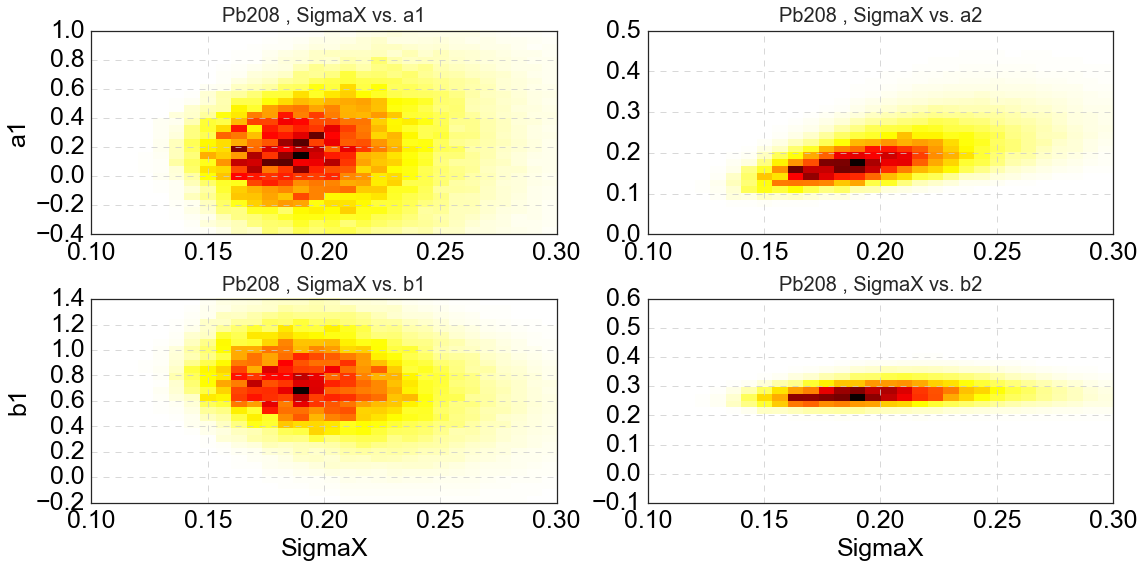

In [15]:
sample = sims_033

for target in ['C12','Al27','Fe56','Pb208']:    
    print 'plotting '+target
#     weights=sample['ks_local_Pval_pcmZ_'+target]
#     weights=sample['ks_Pval_pcmX_pcmY_pcmZ_'+target]
#     weights=sample['ks_Pval_pcmX_pcmY_pcmZ_Bonferroni_'+target]        
#     weights=sample['ks_Pval_pcmX_pcmY_pcmZ_Ruschendorf_'+target]
    weights=sample['Pval_pcmXYZ_binom_'+target]
    fig = plt.figure(figsize=(16,8))
    for i,parameter_i,parameter_j in zip(range(4)
                                               ,['a1','b1']
                                               ,['a2','b2']):
        ax = fig.add_subplot(1 ,2 , i+1)
        ax.set_title( target + ' , ' + parameter_i + ' vs. ' + parameter_j,fontsize=20,y=1.02)
        plot_2d_hist(sample['gen_'+parameter_i],sample['gen_'+parameter_j]
                     ,weights=weights,norm=''
                     ,bins=30
                     ,xlabel=parameter_i,ylabel=parameter_j,ax=ax,fontsize=25);
        ax.grid(linestyle='--',alpha=0.75)
    plt.tight_layout()
    
    fig = plt.figure(figsize=(16,8))
    for i,parameter_i,parameter_j in zip(range(6)
                                               ,['SigmaX','SigmaX','SigmaX','SigmaX']
                                               ,['a1','a2','b1','b2']):
        ax = fig.add_subplot(2 ,2 , i+1)
        weights=sample['Pval_pcmXYZ_binom_'+target]
        ax.set_title( target + ' , ' + parameter_i + ' vs. ' + parameter_j,fontsize=20,y=1.02)
        plot_2d_hist(sample['gen_'+parameter_i],sample['gen_'+parameter_j]
                     ,weights=weights,norm=''
                     ,bins=30
                     ,xlabel=parameter_i if i>=2 else '',ylabel=parameter_j if i==0 or i==2 else '',ax=ax,fontsize=25);
        ax.grid(linestyle='--',alpha=0.75)

    plt.tight_layout()

# focus on transverse width

In [ ]:
cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/DATA/alltargets_dataCMfits.csv')
cm_pars['sigma_t'] = 0.5*(cm_pars['SigmaX']+cm_pars['SigmaY'])
cm_pars['sigma_tErr'] = 0.5*np.sqrt( np.square(cm_pars['SigmaXerr']) + np.square(cm_pars['SigmaXerr']) )
cm_pars_with_correction = cm_pars

In [ ]:
cm_pars_with_correction['sigma_t_final'] = 0.0
cm_pars_with_correction['sigma_t_final_Err'] = 0.0

x = sample['gen_SigmaX'] 
for i,target in zip(range(4),['C12','Al27','Fe56','Pb208']):
    weights=sample['Pval_pcmXYZ_binom_'+target] 
    sigma_t_mean = np.average( x , weights=weights )
    sigma_t_std = np.sqrt( np.average( np.square( x - sigma_t_mean ) , weights=weights) ) 

    cm_pars_with_correction.set_value( i , 'sigma_t_final' , sigma_t_mean )
    cm_pars_with_correction.set_value( i , 'sigma_t_final_Err' ,  sigma_t_std )    

In [ ]:
cm_pars_with_correction

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
plt.plot(cm_pars_with_correction['A'],cm_pars_with_correction['sigma_t'],'s',color='black',label='before correction')
ax.errorbar(x=cm_pars_with_correction['A'],y=cm_pars_with_correction['sigma_t_final'],yerr=cm_pars_with_correction['sigma_t_final_Err'],fmt='s',color='blue',ecolor='blue',label='after correction')

set_axes(ax,'A','$\\sigma_{c.m.}^{t}$ [GeV/c]')
ax.xaxis.set_ticks([12,27,56,208]);ax.yaxis.set_ticks([0.14,0.16,0.18,0.2]);
ax.grid(linestyle='--',alpha=0.8)
ax.legend(fontsize=25,loc='best')

In [10]:
ColleCalc = pd.DataFrame({'A':[4,12 , 27 , 56 , 208],
                        'allpairs':[0.110,0.140,0.144,0.146,0.145],
                        'nl00':[0.110,0.156,0.164,0.172,0.178]},
                         index = ['$^{4}$He','$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])
CiofiCalc = pd.DataFrame({'A':[4 , 12 , 16 , 40 , 56 , 208], # 3 , 
                        's_t':[0.0899 , 0.1393 , 0.1272 , 0.1407 , 0.1328 , 0.1511]}, # 0.0724
                         index = ['$^{4}$He','$^{12}$C','$^{16}$O','$^{40}$Ca','$^{56}$Fe','$^{208}$Pb']) # '$^{3}$He',
MonizCalc = pd.DataFrame({'A':[12 , 40 , 208],
                        '3kF/4':[0.1658 , 0.1883 , 0.1988]},
                         index = ['$^{12}$C','$^{40}$Ca','$^{208}$Pb'])

BNL_Data = pd.DataFrame({'A':[12],'sigma_t_final':[0.143],'sigma_t_final_Err':[0.017]},index = ['$^{12}$C'])
HallA_Data = pd.DataFrame({'A':[12],'sigma_t_final':[0.136],'sigma_t_final_Err':[0.020]},index = ['$^{12}$C'])
Korover_Data = pd.DataFrame({'A':[4],'sigma_t_final':[0.100],'sigma_t_final_Err':[0.020]},index = ['$^{4}$He'])

WI_Data = pd.DataFrame({'A':[ 12 , 27 , 56 , 208], 
                        'sigma_t_final':[0.158 , 0.156 , 0.181 , 0.174], 
                        'sigma_t_final_Err':[0.012 , 0.019 , 0.011 , 0.016]}, 
                         index = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']) 

In [11]:
def plot_data(data , Ashift=0, fmt='o', marker='^',color='red',
                       markersize=15, linewidth=4, 
                       vary=None , varyerr=None , label=None ):
    ax.errorbar((data['A']+Ashift), data['sigma_t_final'], yerr=data['sigma_t_final_Err'],                
                color=color, marker=marker,markersize=markersize,linewidth=linewidth, fmt=fmt,label=label)
    
def plot_calculation_line( data , varx='A',kind='nearest' , vary=None , color='blue' ,linestyle='--', label=None, linewidth=4):
    x = data[varx]
    y = data[vary]
    itp = interp1d(x,y, kind='linear')

    if kind is None:
        f = interp1d( x , y )
    else:
        f = interp1d( x , y ,kind=kind)

    window_size, poly_order = 101, 4
    xnew = np.linspace(x.min(),x.max(), num=500, endpoint=True)
    yy_sg = savgol_filter(itp(xnew), window_size, poly_order)
    plt.plot( xnew, yy_sg, linestyle, color=color , label=label, linewidth=linewidth )

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


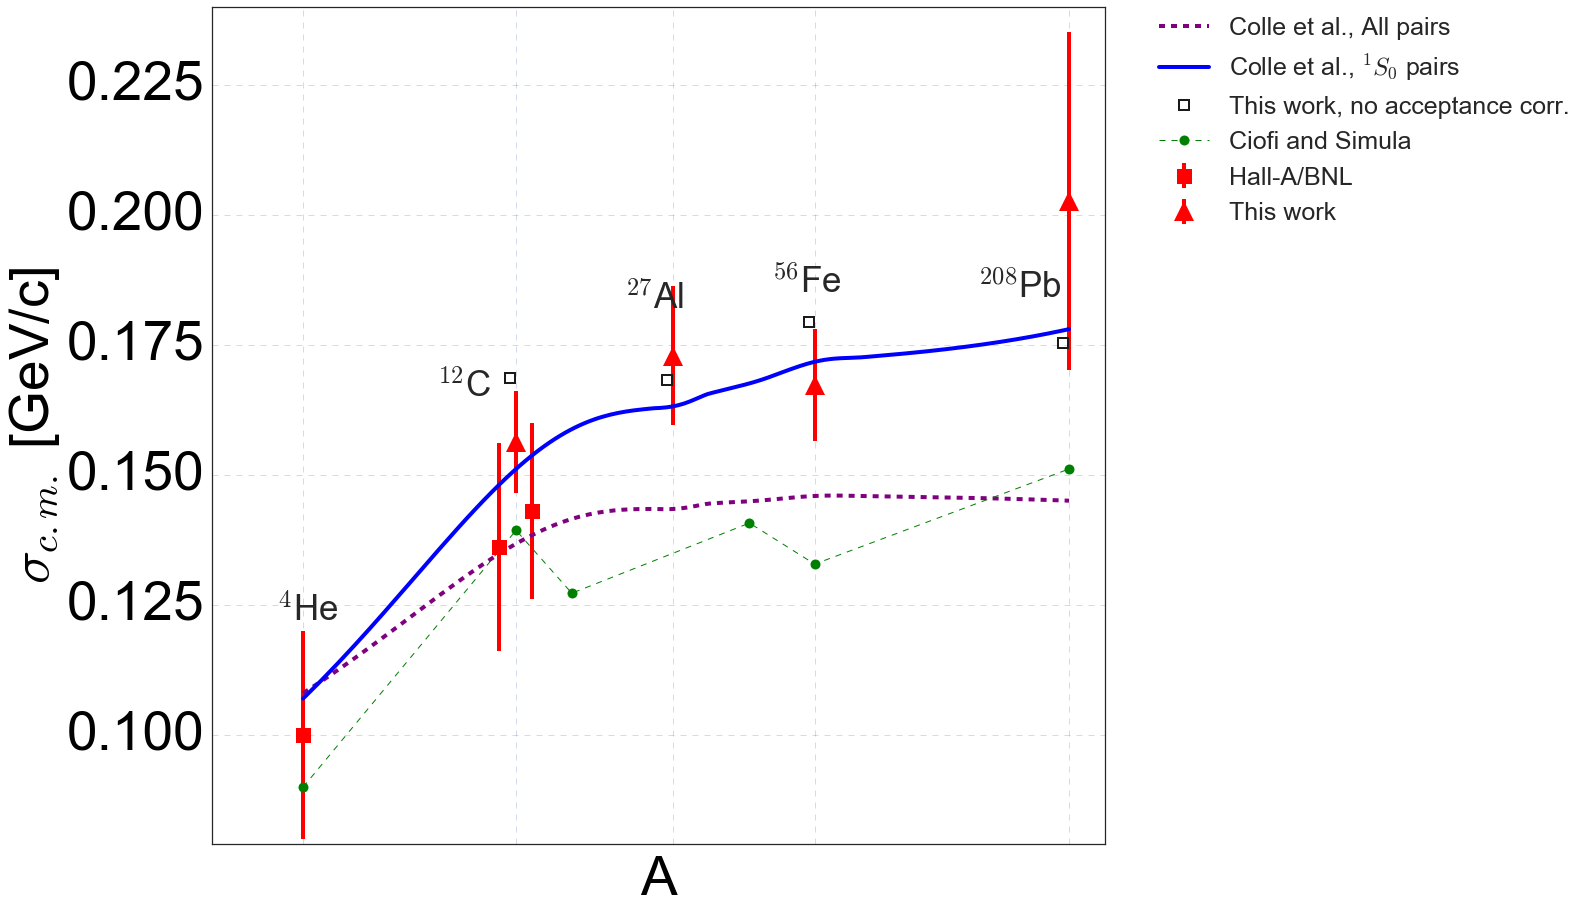

In [12]:
s=30
fig, ax = plt.subplots(figsize=(16,15))
plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' , vary='allpairs',color='purple' ,label='Colle et al., All pairs')
plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' ,linestyle='-', vary='nl00',label='Colle et al., $^1S_0$ pairs')
ax.errorbar(CiofiCalc.A, CiofiCalc.s_t,color='green',fmt='--o',ms=10,linewidth=1,label='Ciofi and Simula')

plot_data( data=BNL_Data, Ashift=1 , marker='s', label=None )
plot_data( data=HallA_Data, Ashift=-1 , marker='s' , label='Hall-A/BNL' )
plot_data( data=Korover_Data , marker='s' , label=None )

ax.plot(0.97*cm_pars['A'], cm_pars['sigma_t'] ,color='red', marker='s',mfc='none',lw = 2, mew = 2, ms = 10, linewidth=0, label='This work, no acceptance corr.')
plot_data( data=cm_pars_with_correction, label='This work', markersize=20 )

ax.set_xscale('log')


set_axes(ax , 'A' , '$\sigma_{c.m.}$ [GeV/c]' , fontsize=55 , xticks=[4,12,27,56,208]
         ,yticks=[0.1,0.125,0.15,0.175,0.2,0.225])
ax.legend(fontsize=25,bbox_to_anchor=(1.05, 1), borderaxespad=0.,loc=2)
ax.grid(b=True, which='major', color='b', linestyle='--',alpha=0.25)

ax.set_xlim(2.5,250);
ax.set_ylim(0.079,0.240);
ax.text(3.5,0.122,'$^4$He',fontsize=35)
ax.text(8,0.165,'$^{12}$C',fontsize=35)
ax.text(21,0.182,'$^{27}$Al',fontsize=35)
ax.text(45,0.185,'$^{56}$Fe',fontsize=35)
ax.text(130,0.184,'$^{208}$Pb',fontsize=35)

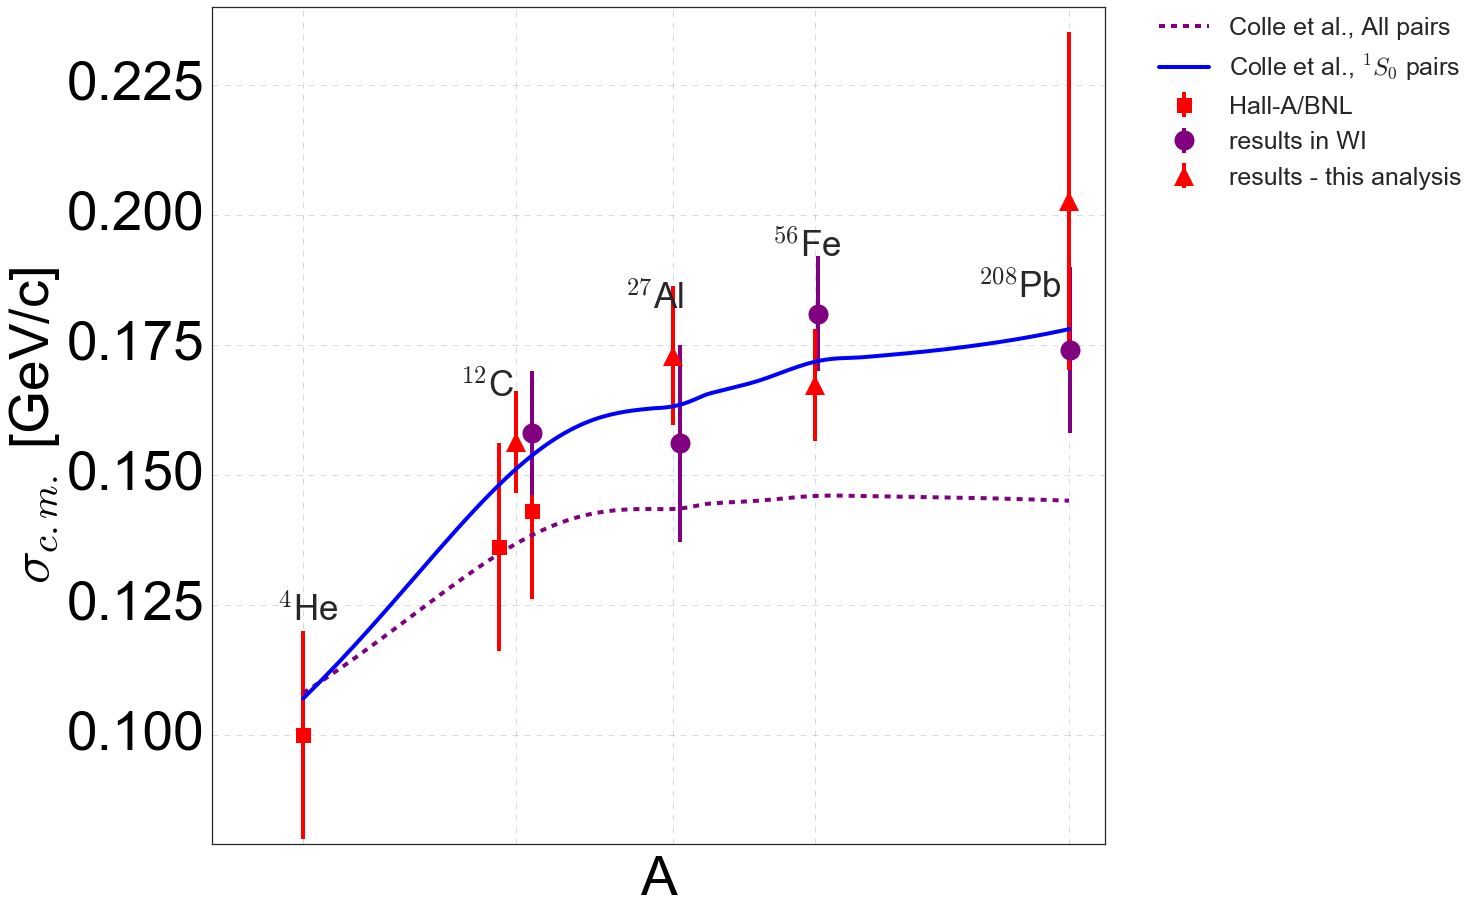

In [13]:
fig, ax = plt.subplots(figsize=(16,15))
plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' , vary='allpairs',color='purple' ,label='Colle et al., All pairs')
plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' ,linestyle='-', vary='nl00',label='Colle et al., $^1S_0$ pairs')

plot_data( data=BNL_Data, Ashift=1 , marker='s', label=None )
plot_data( data=HallA_Data, Ashift=-1 , marker='s' , label='Hall-A/BNL' )
plot_data( data=Korover_Data , marker='s' , label=None )

plot_data( data=WI_Data, label='results in WI',Ashift=1,  markersize=20 , marker='o', color='purple')
plot_data( data=cm_pars_with_correction, label='results - this analysis', markersize=20 )

ax.set_xscale('log')

set_axes(ax , 'A' , '$\sigma_{c.m.}$ [GeV/c]' , fontsize=55 , xticks=[4,12,27,56,208]
         ,yticks=[0.1,0.125,0.15,0.175,0.2,0.225])
ax.legend(fontsize=25,bbox_to_anchor=(1.05, 1), borderaxespad=0.,loc=2)
ax.grid(b=True, which='major', color='b', linestyle='--',alpha=0.25)

ax.set_xlim(2.5,250);
ax.set_ylim(0.079,0.240);
ax.text(3.5,0.122,'$^4$He',fontsize=35)
ax.text(9,0.165,'$^{12}$C',fontsize=35)
ax.text(21,0.182,'$^{27}$Al',fontsize=35)
ax.text(45,0.192,'$^{56}$Fe',fontsize=35)
ax.text(130,0.184,'$^{208}$Pb',fontsize=35)

# longitudinal parameters

In [14]:
Nmax_Nattempts_cuts = 70

fig = plt.figure(figsize=(36,16))


for i_tgt,target,name in zip(range(4),['C12','Al27','Fe56','Pb208'],['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']):
    max_Nattempts_cuts = np.linspace( 10000 , 70000 , Nmax_Nattempts_cuts )
    frac , mean_gen_sigmaX , mean_gen_sigmaX_err = [] , [] , []
    for max_Nattempts_cut in max_Nattempts_cuts:
        reduced = sims[sims['Nattempts']<max_Nattempts_cut]
        x = reduced['gen_SigmaX']
        weights=reduced['ks_Pval_pcmX_pcmY_pcmZ_scaled_1e20_'+target]
        frac.append(100*float(len(reduced))/len(sims))
        mean_gen_sigmaX.append (np.average( x , weights=weights) )
        mean_gen_sigmaX_err.append ( np.sqrt( np.average( np.square( x-mean_gen_sigmaX[-1] ) , weights=weights)) )

    ax=fig.add_subplot(2,2,i_tgt+1)
    plt.errorbar( max_Nattempts_cuts , y=mean_gen_sigmaX , yerr=mean_gen_sigmaX_err , fmt='o' , ecolor='black')
    set_axes(ax,'$N_{attempts}^{max}$ cut' if i_tgt==2 or i_tgt==3 else ''
             ,'$\\sigma_{c.m.}^{t}$ [GeV/c]' if i_tgt==0 or i_tgt==2 else ''
             ,title=name,do_add_grid=True, yticks=[0.13,0.15,0.17,0.19,0.21])
    ax.set_ylim(0.12,0.24)
    plt.plot([13000,13000],ax.get_ylim(),'--',color='black')
    plt.plot([15000,15000],ax.get_ylim(),'--',color='black')
    plt.plot([20000,20000],ax.get_ylim(),'--',color='black')
    
plt.tight_layout()

NameError: name 'sims' is not defined

In [12]:
reduced_sims[['run'        
        ,'gen_SigmaX','gen_a1','gen_a2','gen_b1','gen_b2'
        ,'recMeanX','recMeanY','recSigmaX','recSigmaY'
        ,'reca1','reca2','recb1','recb2'

        ,'ks_local_Pval_pcmX_C12','ks_local_Pval_pcmY_C12'
        ,'ks_local_Pval_pcmZ_bin0_C12','ks_local_Pval_pcmZ_bin1_C12','ks_local_Pval_pcmZ_bin2_C12','ks_local_Pval_pcmZ_bin3_C12','ks_local_Pval_pcmZ_bin4_C12'
        ,'ks_PvalTotal_C12'

        
        ,'ks_local_Pval_pcmX_Al27','ks_local_Pval_pcmY_Al27'
        ,'ks_local_Pval_pcmZ_bin0_Al27','ks_local_Pval_pcmZ_bin1_Al27','ks_local_Pval_pcmZ_bin2_Al27','ks_local_Pval_pcmZ_bin3_Al27','ks_local_Pval_pcmZ_bin4_Al27'
        ,'ks_PvalTotal_Al27'


        ,'ks_local_Pval_pcmX_Fe56','ks_local_Pval_pcmY_Fe56'
        ,'ks_local_Pval_pcmZ_bin0_Fe56','ks_local_Pval_pcmZ_bin1_Fe56','ks_local_Pval_pcmZ_bin2_Fe56','ks_local_Pval_pcmZ_bin3_Fe56','ks_local_Pval_pcmZ_bin4_Fe56'
        ,'ks_PvalTotal_Fe56'


        ,'ks_local_Pval_pcmX_Pb208','ks_local_Pval_pcmY_Pb208'
        ,'ks_local_Pval_pcmZ_bin0_Pb208','ks_local_Pval_pcmZ_bin1_Pb208','ks_local_Pval_pcmZ_bin2_Pb208','ks_local_Pval_pcmZ_bin3_Pb208','ks_local_Pval_pcmZ_bin4_Pb208'
        ,'ks_PvalTotal_Pb208'


       ]].to_root('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/random_parameters_results/Ntimes10_OrTrees_Nattampts.root'
               ,key='simsTree')